<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Predicting_Google_mobility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -U tensorflow-addons
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from keras.layers import LayerNormalization
from keras.layers import Flatten
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
import tensorflow
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
import random



In [7]:
data = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

data = pd.DataFrame(data)

# select Thailand only
data = data.loc[data['CountryName'] == "Thailand"]

# select columns
data = data[["Date", "C1_School closing",
            "C2_Workplace closing",
            "C3_Cancel public events", "C4_Restrictions on gatherings",
            "C5_Close public transport", "C6_Stay at home requirements",
            "C7_Restrictions on internal movement", "C8_International travel controls",
            "H1_Public information campaigns", "ConfirmedCases", "ConfirmedDeaths"]]

# change column names
data = data.rename(columns = {"C1_School closing":"C1_School.closing",
            "C2_Workplace closing":"C2_Workplace.closing",
            "C3_Cancel public events":"C3_Cancel.public.events",
            "C4_Restrictions on gatherings":"C4_Restrictions.on.gatherings",
            "C5_Close public transport":"C5_Close.public.transport",
            "C6_Stay at home requirements":"C6_Stay.at.home.requirements",
            "C7_Restrictions on internal movement":"C7_Restrictions.on.internal.movement",
            "C8_International travel controls":"C8_International.travel.controls",
            "H1_Public information campaigns":"H1_Public.information.campaigns"})

# change date format
data.Date =  pd.to_datetime(data["Date"], format='%Y%m%d')

# reset index
data = data.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["ConfirmedCases", "ConfirmedDeaths"]] = data[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# remove NaN rows (bottom part)
data = data.dropna()

# add daily cases columns
data[["Cases_daily"]] = data['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
data[["Deaths_daily"]] = data['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
data[["Cases_daily", "Deaths_daily"]] = data[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)


# start from 15/2/2020
data = data[data.loc[data['Date'] == "2020-02-15"].index[0]:]

# reset index
data = data.reset_index(drop = True)

# one-hot encoding
a = pd.DataFrame(to_categorical(data[["C1_School.closing"]]))
b = pd.DataFrame(to_categorical(data[["C2_Workplace.closing"]]))
c = pd.DataFrame(to_categorical(data[["C3_Cancel.public.events"]]))
d = pd.DataFrame(to_categorical(data[["C4_Restrictions.on.gatherings"]]))
e = pd.DataFrame(to_categorical(data[["C5_Close.public.transport"]]))
f = pd.DataFrame(to_categorical(data[["C6_Stay.at.home.requirements"]]))
g = pd.DataFrame(to_categorical(data[["C7_Restrictions.on.internal.movement"]]))
h = pd.DataFrame(to_categorical(data[["C8_International.travel.controls"]]))
j = pd.DataFrame(to_categorical(data[["H1_Public.information.campaigns"]]))






/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.



In [8]:
mob = read_csv("https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv")

mob = pd.DataFrame(mob)

# select only Thailand
mob = mob.loc[mob['country_region'] == "Thailand"]

# select columns
mob = mob[["date",
              "retail_and_recreation_percent_change_from_baseline",
              "grocery_and_pharmacy_percent_change_from_baseline",
              "parks_percent_change_from_baseline",
              "transit_stations_percent_change_from_baseline",
              "workplaces_percent_change_from_baseline",
              "residential_percent_change_from_baseline"]]

# change date format
mob.date =  pd.to_datetime(mob["date"])

# change column name
mob = mob.rename(columns = {'date':'Date',
                            "retail_and_recreation_percent_change_from_baseline":'retail',
                            "grocery_and_pharmacy_percent_change_from_baseline": "grocery",
                            "parks_percent_change_from_baseline":'parks',
                            "transit_stations_percent_change_from_baseline":"transit",
                            "workplaces_percent_change_from_baseline":"workplace",
                            "residential_percent_change_from_baseline":"resident"})

# reset index
mob = mob.reset_index(drop = True)

# start from 15/2/2020
mob = mob[mob.loc[mob['Date'] == "2020-02-15"].index[0]:]

# omit Date column
mob0 = mob.drop(["Date"], axis = 1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [9]:
# whichever has fewer data
length = min(len(data), len(mob))

# Cases daily
data_mob = pd.concat([#data.Cases_daily[:length], 
                    # data.Deaths_daily[:length],
                    data.Date[:length], 
                    # a[:length],
                    # b[:length],
                    # c[:length],
                    # d[:length],
                    # e[:length],
                    # f[:length],
                    # g[:length],
                    # h[:length],
                    # j[:length],
                    mob0[:length]], axis = 1)

# start on 1/8/2021
data_mob0 = data_mob[data_mob.loc[data_mob['Date'] == "2021-06-15"].index[0]:].reset_index(drop = True)

# plt.rcParams["figure.figsize"] = (20,10)
# plt.plot(data_mob["Date"], data_mob['retail'])
# plt.plot(data_mob["Date"], data_mob['grocery'])
# plt.plot(data_mob["Date"], data_mob['parks'])
# plt.plot(data_mob["Date"], data_mob['transit'])
# plt.plot(data_mob["Date"], data_mob['workplace'])
# plt.plot(data_mob["Date"], data_mob['resident'])
# plt.tick_params('x',labelrotation=90)

# drop date column
data_mob = data_mob0.drop(["Date"], axis = 1)


In [10]:
lag = 14
prediction = 1
window = 3 # for moving average
index = 30

# moving average
# data_mob['Cases_daily'] = data_mob.Cases_daily.rolling(window).mean()
# data_mob['Deaths_daily'] = data_mob.Deaths_daily.rolling(window).mean()

# data_mob['retail'] = data_mob.retail.rolling(window).mean()
# data_mob['grocery'] = data_mob.grocery.rolling(window).mean()
# data_mob['parks'] = data_mob.parks.rolling(window).mean()
# data_mob['transit'] = data_mob.transit.rolling(window).mean()
# data_mob['workplace'] = data_mob.workplace.rolling(window).mean()
# data_mob['resident'] = data_mob.resident.rolling(window).mean()

# remove NaN
data_mob.dropna(subset = [#"Cases_daily", "Deaths_daily",
                          "retail","grocery","parks","transit","workplace","resident"], inplace=True)

data_mob = data_mob.reset_index(drop = True)

nrow_total = data_mob.shape[0]-lag
# input_list = [np.expand_dims(data_mob[i:lag+i], axis=0) for i in range(nrow_total)] 
# X_mob = np.concatenate(input_list, axis=0)

y_mob = list()
for col in data_mob[["retail","grocery","parks","transit","workplace","resident"]]:
  input_list = [np.expand_dims(data_mob[lag+i:lag+i+1][col], axis=0) for i in range(nrow_total)] 
  y = np.concatenate(input_list, axis=0)
  y_mob.append(y)
y_mob = np.array(y_mob)
y_mob = y_mob.swapaxes(0,1).swapaxes(1,2)

# split into training and test sets
# X_mob_tr = X_mob[0:index+1, :, :]
# X_mob_ts = X_mob[index+1:data_mob.shape[0], :, :]



# Retail

In [11]:

input_list = [np.expand_dims(data_mob.retail[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

# split into training and test sets
X_mob_tr_retail = X_mob[0:index+1, :]
X_mob_tr_retail = X_mob_tr_retail.reshape(X_mob_tr_retail.shape[0], X_mob_tr_retail.shape[1], 1)
X_mob_ts_retail = X_mob[index+1:data_mob.shape[0], :]
X_mob_ts_retail = X_mob_ts_retail.reshape(X_mob_ts_retail.shape[0], X_mob_ts_retail.shape[1], 1)

y_mob_tr_retail = y_mob[0:index+1, :, 0]
y_mob_ts_retail = y_mob[index+1:data_mob.shape[0], :, 0] # retail

## Tuning

In [12]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob_retail = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr_retail, y_mob_tr_retail)
    cnn_mob_retail.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr_retail, y_mob_tr_retail)
    cnn_mob_retail.append(score)

cnn_mob_retail = pd.DataFrame(cnn_mob_retail).T
cnn_mob_retail.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 17.022
filter = 4, kernel size = 3, pooling size = 2: 19.880
filter = 8, kernel size = 3, pooling size = 2: 17.857
filter = 16, kernel size = 3, pooling size = 2: 15.644
filter = 32, kernel size = 3, pooling size = 2: 14.908
filter = 64, kernel size = 3, pooling size = 2: 10.615
filter = 128, kernel size = 3, pooling size = 2: 10.784
filter = 256, kernel size = 3, pooling size = 2: 9.629
filter = 512, kernel size = 3, pooling size = 2: 8.781
filter = 1024, kernel size = 3, pooling size = 2: 8.147
filter = 2, kernel size = 5, pooling size = 2: 21.636
filter = 4, kernel size = 5, pooling size = 2: 89.070
filter = 8, kernel size = 5, pooling size = 2: 17.539
filter = 16, kernel size = 5, pooling size = 2: 17.068
filter = 32, kernel size = 5, pooling size = 2: 13.191
filter = 64, kernel size = 5, pooling size = 2: 12.724
filter = 128, kernel size = 5, pooling size = 2: 10.595
filter = 256, kernel size = 5, pooling size = 2: 10.741
filter = 512

In [13]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob_retail = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr_retail, y_mob_tr_retail, i)
  lstm_mob_retail.append(score)

In [14]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob_retail = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr_retail, y_mob_tr_retail, i)
  gru_mob_retail.append(score)

In [15]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob_retail = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr_retail, y_mob_tr_retail, i)
  rnn_mob_retail.append(score)

### Table

In [16]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob_retail[0],3), 
                                     round(gru_mob_retail[0],3),
                                     round(rnn_mob_retail[0],3), 
                                     round(cnn_mob_retail.iloc[0,0],3),
                                     round(cnn_mob_retail.iloc[0,1],3),
                                     round(cnn_mob_retail.iloc[0,2],3),
                                     round(cnn_mob_retail.iloc[0,3],3),
                                     round(cnn_mob_retail.iloc[0,4],3),
                                     round(cnn_mob_retail.iloc[0,5],3)],
                                     [round(lstm_mob_retail[1],3), 
                                     round(gru_mob_retail[1],3),
                                     round(rnn_mob_retail[1],3), 
                                     round(cnn_mob_retail.iloc[1,0],3),
                                     round(cnn_mob_retail.iloc[1,1],3),
                                     round(cnn_mob_retail.iloc[1,2],3),
                                     round(cnn_mob_retail.iloc[1,3],3),
                                     round(cnn_mob_retail.iloc[1,4],3),
                                     round(cnn_mob_retail.iloc[1,5],3)],
                                     [round(lstm_mob_retail[2],3), 
                                     round(gru_mob_retail[2],3),
                                     round(rnn_mob_retail[2],3), 
                                     round(cnn_mob_retail.iloc[2,0],3),
                                     round(cnn_mob_retail.iloc[2,1],3),
                                     round(cnn_mob_retail.iloc[2,2],3),
                                     round(cnn_mob_retail.iloc[2,3],3),
                                     round(cnn_mob_retail.iloc[2,4],3),
                                     round(cnn_mob_retail.iloc[2,5],3)],
                                     [round(lstm_mob_retail[3],3), 
                                     round(gru_mob_retail[3],3),
                                     round(rnn_mob_retail[3],3), 
                                     round(cnn_mob_retail.iloc[3,0],3),
                                     round(cnn_mob_retail.iloc[3,1],3),
                                     round(cnn_mob_retail.iloc[3,2],3),
                                     round(cnn_mob_retail.iloc[3,3],3),
                                     round(cnn_mob_retail.iloc[3,4],3),
                                     round(cnn_mob_retail.iloc[3,5],3)],
                                     [round(lstm_mob_retail[4],3), 
                                     round(gru_mob_retail[4],3),
                                     round(rnn_mob_retail[4],3), 
                                     round(cnn_mob_retail.iloc[4,0],3),
                                     round(cnn_mob_retail.iloc[4,1],3),
                                     round(cnn_mob_retail.iloc[4,2],3),
                                     round(cnn_mob_retail.iloc[4,3],3),
                                     round(cnn_mob_retail.iloc[4,4],3),
                                     round(cnn_mob_retail.iloc[4,5],3)],
                                     [round(lstm_mob_retail[5],3), 
                                     round(gru_mob_retail[5],3),
                                     round(rnn_mob_retail[5],3), 
                                     round(cnn_mob_retail.iloc[5,0],3),
                                     round(cnn_mob_retail.iloc[5,1],3),
                                     round(cnn_mob_retail.iloc[5,2],3),
                                     round(cnn_mob_retail.iloc[5,3],3),
                                     round(cnn_mob_retail.iloc[5,4],3),
                                     round(cnn_mob_retail.iloc[5,5],3)],
                                     [round(lstm_mob_retail[6],3), 
                                     round(gru_mob_retail[6],3),
                                     round(rnn_mob_retail[6],3), 
                                     round(cnn_mob_retail.iloc[6,0],3),
                                     round(cnn_mob_retail.iloc[6,1],3),
                                     round(cnn_mob_retail.iloc[6,2],3),
                                     round(cnn_mob_retail.iloc[6,3],3),
                                     round(cnn_mob_retail.iloc[6,4],3),
                                     round(cnn_mob_retail.iloc[6,5],3)],
                                     [round(lstm_mob_retail[7],3), 
                                     round(gru_mob_retail[7],3),
                                     round(rnn_mob_retail[7],3), 
                                     round(cnn_mob_retail.iloc[7,0],3),
                                     round(cnn_mob_retail.iloc[7,1],3),
                                     round(cnn_mob_retail.iloc[7,2],3),
                                     round(cnn_mob_retail.iloc[7,3],3),
                                     round(cnn_mob_retail.iloc[7,4],3),
                                     round(cnn_mob_retail.iloc[7,5],3)],
                                     [round(lstm_mob_retail[8],3), 
                                     round(gru_mob_retail[8],3),
                                     round(rnn_mob_retail[8],3), 
                                     round(cnn_mob_retail.iloc[8,0],3),
                                     round(cnn_mob_retail.iloc[8,1],3),
                                     round(cnn_mob_retail.iloc[8,2],3),
                                     round(cnn_mob_retail.iloc[8,3],3),
                                     round(cnn_mob_retail.iloc[8,4],3),
                                     round(cnn_mob_retail.iloc[8,5],3)],
                                     [round(lstm_mob_retail[9],3), 
                                     round(gru_mob_retail[9],3),
                                     round(rnn_mob_retail[9],3), 
                                     round(cnn_mob_retail.iloc[9,0],3),
                                     round(cnn_mob_retail.iloc[9,1],3),
                                     round(cnn_mob_retail.iloc[9,2],3),
                                     round(cnn_mob_retail.iloc[9,3],3),
                                     round(cnn_mob_retail.iloc[9,4],3),
                                     round(cnn_mob_retail.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [17]:
seed(1)
tensorflow.random.set_seed(1)

model_mob_retail = Sequential()
model_mob_retail.add(LSTM(64, activation='relu', input_shape=(X_mob_tr_retail.shape[1], X_mob_tr_retail.shape[2])))
# model_mob_retail.add(Dense(16, activation = "relu"))
# model_mob_retail.add(Dense(2, activation = "relu"))
model_mob_retail.add(Dense(1, activation = "linear"))
model_mob_retail.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# model_mob_retail = Sequential()
# model_mob_retail.add(Conv1D(64, kernel_size = 5, activation='relu', input_shape=(X_mob_tr_retail.shape[1], X_mob_tr_retail.shape[2])))
# model_mob_retail.add(MaxPooling1D(2))
# model_mob_retail.add(Flatten())
# # model_mob_retail.add(Dense(16, activation = "relu"))
# # model_mob_retail.add(Dense(2, activation = "relu"))
# model_mob_retail.add(Dense(1, activation = "linear"))
# model_mob_retail.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_retail.fit(X_mob_tr_retail, y_mob_tr_retail, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob_retail.evaluate(X_mob_tr_retail, y_mob_tr_retail, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob_retail.evaluate(X_mob_ts_retail, y_mob_ts_retail, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr_retail = pd.DataFrame(model_mob_retail.predict(X_mob_tr_retail))

# test set
y_mob_ts_retail = pd.DataFrame(model_mob_retail.predict(X_mob_ts_retail))

# combine training and test predictions
y_mob_total_retail = pd.concat([y_mob_tr_retail, y_mob_ts_retail], ignore_index=True)



MAPE: training =  7.477477550506592
MAPE: test =  250882496.0


## Plot

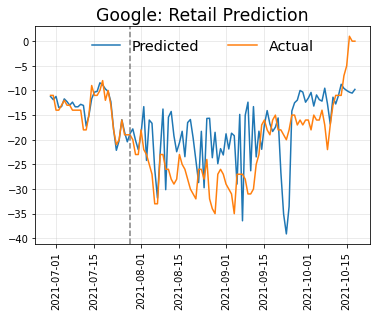

In [18]:

retail = pd.concat([y_mob_total_retail,
                data_mob0.retail.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

retail.columns = ['retail', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(retail['Date'],retail['retail'], label = "Predicted")
plt.plot(retail['Date'],retail['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Retail Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Grocery

In [19]:
input_list = [np.expand_dims(data_mob.grocery[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

# split into training and test sets
X_mob_tr_grocery = X_mob[0:index+1, :]
X_mob_tr_grocery = X_mob_tr_grocery.reshape(X_mob_tr_grocery.shape[0], X_mob_tr_grocery.shape[1], 1)
X_mob_ts_grocery = X_mob[index+1:data_mob.shape[0], :]
X_mob_ts_grocery = X_mob_ts_grocery.reshape(X_mob_ts_grocery.shape[0], X_mob_ts_grocery.shape[1], 1)


y_mob_tr_grocery = y_mob[0:index+1, :, 1]
y_mob_ts_grocery = y_mob[index+1:data_mob.shape[0], :, 1] # grocery

## Tuning

In [20]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob_grocery = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr_grocery, y_mob_tr_grocery)
    cnn_mob_grocery.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr_grocery, y_mob_tr_grocery)
    cnn_mob_grocery.append(score)

cnn_mob_grocery = pd.DataFrame(cnn_mob_grocery).T
cnn_mob_grocery.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 26.343
filter = 4, kernel size = 3, pooling size = 2: 19.644
filter = 8, kernel size = 3, pooling size = 2: 22.169
filter = 16, kernel size = 3, pooling size = 2: 21.716
filter = 32, kernel size = 3, pooling size = 2: 16.365
filter = 64, kernel size = 3, pooling size = 2: 17.894
filter = 128, kernel size = 3, pooling size = 2: 16.484
filter = 256, kernel size = 3, pooling size = 2: 13.480
filter = 512, kernel size = 3, pooling size = 2: 11.791
filter = 1024, kernel size = 3, pooling size = 2: 12.297
filter = 2, kernel size = 5, pooling size = 2: 23.294
filter = 4, kernel size = 5, pooling size = 2: 19.293
filter = 8, kernel size = 5, pooling size = 2: 18.758
filter = 16, kernel size = 5, pooling size = 2: 18.987
filter = 32, kernel size = 5, pooling size = 2: 17.556
filter = 64, kernel size = 5, pooling size = 2: 17.323
filter = 128, kernel size = 5, pooling size = 2: 14.621
filter = 256, kernel size = 5, pooling size = 2: 13.338
filter = 

In [21]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob_grocery = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr_grocery, y_mob_tr_grocery, i)
  lstm_mob_grocery.append(score)

In [22]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob_grocery = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr_grocery, y_mob_tr_grocery, i)
  gru_mob_grocery.append(score)

In [23]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob_grocery = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr_grocery, y_mob_tr_grocery, i)
  rnn_mob_grocery.append(score)

### Table

In [24]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob_grocery[0],3), 
                                     round(gru_mob_grocery[0],3),
                                     round(rnn_mob_grocery[0],3), 
                                     round(cnn_mob_grocery.iloc[0,0],3),
                                     round(cnn_mob_grocery.iloc[0,1],3),
                                     round(cnn_mob_grocery.iloc[0,2],3),
                                     round(cnn_mob_grocery.iloc[0,3],3),
                                     round(cnn_mob_grocery.iloc[0,4],3),
                                     round(cnn_mob_grocery.iloc[0,5],3)],
                                     [round(lstm_mob_grocery[1],3), 
                                     round(gru_mob_grocery[1],3),
                                     round(rnn_mob_grocery[1],3), 
                                     round(cnn_mob_grocery.iloc[1,0],3),
                                     round(cnn_mob_grocery.iloc[1,1],3),
                                     round(cnn_mob_grocery.iloc[1,2],3),
                                     round(cnn_mob_grocery.iloc[1,3],3),
                                     round(cnn_mob_grocery.iloc[1,4],3),
                                     round(cnn_mob_grocery.iloc[1,5],3)],
                                     [round(lstm_mob_grocery[2],3), 
                                     round(gru_mob_grocery[2],3),
                                     round(rnn_mob_grocery[2],3), 
                                     round(cnn_mob_grocery.iloc[2,0],3),
                                     round(cnn_mob_grocery.iloc[2,1],3),
                                     round(cnn_mob_grocery.iloc[2,2],3),
                                     round(cnn_mob_grocery.iloc[2,3],3),
                                     round(cnn_mob_grocery.iloc[2,4],3),
                                     round(cnn_mob_grocery.iloc[2,5],3)],
                                     [round(lstm_mob_grocery[3],3), 
                                     round(gru_mob_grocery[3],3),
                                     round(rnn_mob_grocery[3],3), 
                                     round(cnn_mob_grocery.iloc[3,0],3),
                                     round(cnn_mob_grocery.iloc[3,1],3),
                                     round(cnn_mob_grocery.iloc[3,2],3),
                                     round(cnn_mob_grocery.iloc[3,3],3),
                                     round(cnn_mob_grocery.iloc[3,4],3),
                                     round(cnn_mob_grocery.iloc[3,5],3)],
                                     [round(lstm_mob_grocery[4],3), 
                                     round(gru_mob_grocery[4],3),
                                     round(rnn_mob_grocery[4],3), 
                                     round(cnn_mob_grocery.iloc[4,0],3),
                                     round(cnn_mob_grocery.iloc[4,1],3),
                                     round(cnn_mob_grocery.iloc[4,2],3),
                                     round(cnn_mob_grocery.iloc[4,3],3),
                                     round(cnn_mob_grocery.iloc[4,4],3),
                                     round(cnn_mob_grocery.iloc[4,5],3)],
                                     [round(lstm_mob_grocery[5],3), 
                                     round(gru_mob_grocery[5],3),
                                     round(rnn_mob_grocery[5],3), 
                                     round(cnn_mob_grocery.iloc[5,0],3),
                                     round(cnn_mob_grocery.iloc[5,1],3),
                                     round(cnn_mob_grocery.iloc[5,2],3),
                                     round(cnn_mob_grocery.iloc[5,3],3),
                                     round(cnn_mob_grocery.iloc[5,4],3),
                                     round(cnn_mob_grocery.iloc[5,5],3)],
                                     [round(lstm_mob_grocery[6],3), 
                                     round(gru_mob_grocery[6],3),
                                     round(rnn_mob_grocery[6],3), 
                                     round(cnn_mob_grocery.iloc[6,0],3),
                                     round(cnn_mob_grocery.iloc[6,1],3),
                                     round(cnn_mob_grocery.iloc[6,2],3),
                                     round(cnn_mob_grocery.iloc[6,3],3),
                                     round(cnn_mob_grocery.iloc[6,4],3),
                                     round(cnn_mob_grocery.iloc[6,5],3)],
                                     [round(lstm_mob_grocery[7],3), 
                                     round(gru_mob_grocery[7],3),
                                     round(rnn_mob_grocery[7],3), 
                                     round(cnn_mob_grocery.iloc[7,0],3),
                                     round(cnn_mob_grocery.iloc[7,1],3),
                                     round(cnn_mob_grocery.iloc[7,2],3),
                                     round(cnn_mob_grocery.iloc[7,3],3),
                                     round(cnn_mob_grocery.iloc[7,4],3),
                                     round(cnn_mob_grocery.iloc[7,5],3)],
                                     [round(lstm_mob_grocery[8],3), 
                                     round(gru_mob_grocery[8],3),
                                     round(rnn_mob_grocery[8],3), 
                                     round(cnn_mob_grocery.iloc[8,0],3),
                                     round(cnn_mob_grocery.iloc[8,1],3),
                                     round(cnn_mob_grocery.iloc[8,2],3),
                                     round(cnn_mob_grocery.iloc[8,3],3),
                                     round(cnn_mob_grocery.iloc[8,4],3),
                                     round(cnn_mob_grocery.iloc[8,5],3)],
                                     [round(lstm_mob_grocery[9],3), 
                                     round(gru_mob_grocery[9],3),
                                     round(rnn_mob_grocery[9],3), 
                                     round(cnn_mob_grocery.iloc[9,0],3),
                                     round(cnn_mob_grocery.iloc[9,1],3),
                                     round(cnn_mob_grocery.iloc[9,2],3),
                                     round(cnn_mob_grocery.iloc[9,3],3),
                                     round(cnn_mob_grocery.iloc[9,4],3),
                                     round(cnn_mob_grocery.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [25]:

seed(1)
tensorflow.random.set_seed(1)

# model_mob_grocery = Sequential()
# model_mob_grocery.add(Conv1D(64, kernel_size = 7, activation='relu', input_shape=(X_mob_tr_grocery.shape[1], X_mob_tr_grocery.shape[2])))
# model_mob_grocery.add(MaxPooling1D(2))
# model_mob_grocery.add(Flatten())
# # model_mob_grocery.add(Dense(2, activation = "relu"))
# model_mob_grocery.add(Dense(1, activation = "linear"))
# model_mob_grocery.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_mob_grocery = Sequential()
model_mob_grocery.add(LSTM(512, activation='relu', input_shape=(X_mob_tr_grocery.shape[1], X_mob_tr_grocery.shape[2])))
# model_mob_grocery.add(Dense(8, activation = "relu"))
model_mob_grocery.add(Dense(1, activation = "linear"))
model_mob_grocery.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_grocery.fit(X_mob_tr_grocery, y_mob_tr_grocery, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob_grocery.evaluate(X_mob_tr_grocery, y_mob_tr_grocery, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob_grocery.evaluate(X_mob_ts_grocery, y_mob_ts_grocery, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr_grocery = pd.DataFrame(model_mob_grocery.predict(X_mob_tr_grocery))

# test set
y_mob_ts_grocery = pd.DataFrame(model_mob_grocery.predict(X_mob_ts_grocery))

# combine training and test predictions
y_mob_total_grocery = pd.concat([y_mob_tr_grocery, y_mob_ts_grocery], ignore_index=True)



MAPE: training =  10.693365097045898
MAPE: test =  76975904.0


## Plot

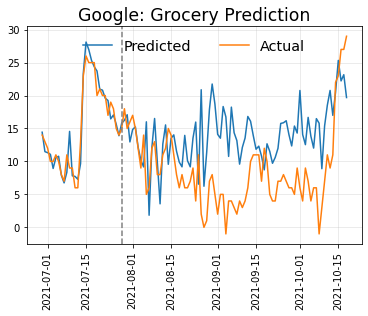

In [26]:

grocery = pd.concat([y_mob_total_grocery,
                data_mob0.grocery.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

grocery.columns = ['grocery', "Actual", 'Date']


plt.plot(grocery['Date'],grocery['grocery'], label = "Predicted")
plt.plot(grocery['Date'],grocery['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Grocery Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Parks

In [27]:
input_list = [np.expand_dims(data_mob.parks[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

# split into training and test sets
X_mob_tr_parks = X_mob[0:index+1, :]
X_mob_tr_parks = X_mob_tr_parks.reshape(X_mob_tr_parks.shape[0], X_mob_tr_parks.shape[1], 1)
X_mob_ts_parks = X_mob[index+1:data_mob.shape[0], :]
X_mob_ts_parks = X_mob_ts_parks.reshape(X_mob_ts_parks.shape[0], X_mob_ts_parks.shape[1], 1)


y_mob_tr_parks = y_mob[0:index+1, :, 2]
y_mob_ts_parks = y_mob[index+1:data_mob.shape[0], :, 2] # parks

## Tuning

In [28]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob_parks = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr_parks, y_mob_tr_parks)
    cnn_mob_parks.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr_parks, y_mob_tr_parks)
    cnn_mob_parks.append(score)

cnn_mob_parks = pd.DataFrame(cnn_mob_parks).T
cnn_mob_parks.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 7.689
filter = 4, kernel size = 3, pooling size = 2: 7.422
filter = 8, kernel size = 3, pooling size = 2: 7.744
filter = 16, kernel size = 3, pooling size = 2: 7.014
filter = 32, kernel size = 3, pooling size = 2: 7.193
filter = 64, kernel size = 3, pooling size = 2: 8.312
filter = 128, kernel size = 3, pooling size = 2: 8.965
filter = 256, kernel size = 3, pooling size = 2: 7.759
filter = 512, kernel size = 3, pooling size = 2: 6.644
filter = 1024, kernel size = 3, pooling size = 2: 6.100
filter = 2, kernel size = 5, pooling size = 2: 95.889
filter = 4, kernel size = 5, pooling size = 2: 95.896
filter = 8, kernel size = 5, pooling size = 2: 7.557
filter = 16, kernel size = 5, pooling size = 2: 7.542
filter = 32, kernel size = 5, pooling size = 2: 7.714
filter = 64, kernel size = 5, pooling size = 2: 8.590
filter = 128, kernel size = 5, pooling size = 2: 9.255
filter = 256, kernel size = 5, pooling size = 2: 7.961
filter = 512, kernel size

In [29]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob_parks = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr_parks, y_mob_tr_parks, i)
  lstm_mob_parks.append(score)

In [30]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob_parks = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr_parks, y_mob_tr_parks, i)
  gru_mob_parks.append(score)

In [31]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob_parks = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr_parks, y_mob_tr_parks, i)
  rnn_mob_parks.append(score)

### Table

In [60]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob_parks[0],3), 
                                     round(gru_mob_parks[0],3),
                                     round(rnn_mob_parks[0],3), 
                                     round(cnn_mob_parks.iloc[0,0],3),
                                     round(cnn_mob_parks.iloc[0,1],3),
                                     round(cnn_mob_parks.iloc[0,2],3),
                                     round(cnn_mob_parks.iloc[0,3],3),
                                     round(cnn_mob_parks.iloc[0,4],3),
                                     round(cnn_mob_parks.iloc[0,5],3)],
                                     [round(lstm_mob_parks[1],3), 
                                     round(gru_mob_parks[1],3),
                                     round(rnn_mob_parks[1],3), 
                                     round(cnn_mob_parks.iloc[1,0],3),
                                     round(cnn_mob_parks.iloc[1,1],3),
                                     round(cnn_mob_parks.iloc[1,2],3),
                                     round(cnn_mob_parks.iloc[1,3],3),
                                     round(cnn_mob_parks.iloc[1,4],3),
                                     round(cnn_mob_parks.iloc[1,5],3)],
                                     [round(lstm_mob_parks[2],3), 
                                     round(gru_mob_parks[2],3),
                                     round(rnn_mob_parks[2],3), 
                                     round(cnn_mob_parks.iloc[2,0],3),
                                     round(cnn_mob_parks.iloc[2,1],3),
                                     round(cnn_mob_parks.iloc[2,2],3),
                                     round(cnn_mob_parks.iloc[2,3],3),
                                     round(cnn_mob_parks.iloc[2,4],3),
                                     round(cnn_mob_parks.iloc[2,5],3)],
                                     [round(lstm_mob_parks[3],3), 
                                     round(gru_mob_parks[3],3),
                                     round(rnn_mob_parks[3],3), 
                                     round(cnn_mob_parks.iloc[3,0],3),
                                     round(cnn_mob_parks.iloc[3,1],3),
                                     round(cnn_mob_parks.iloc[3,2],3),
                                     round(cnn_mob_parks.iloc[3,3],3),
                                     round(cnn_mob_parks.iloc[3,4],3),
                                     round(cnn_mob_parks.iloc[3,5],3)],
                                     [round(lstm_mob_parks[4],3), 
                                     round(gru_mob_parks[4],3),
                                     round(rnn_mob_parks[4],3), 
                                     round(cnn_mob_parks.iloc[4,0],3),
                                     round(cnn_mob_parks.iloc[4,1],3),
                                     round(cnn_mob_parks.iloc[4,2],3),
                                     round(cnn_mob_parks.iloc[4,3],3),
                                     round(cnn_mob_parks.iloc[4,4],3),
                                     round(cnn_mob_parks.iloc[4,5],3)],
                                     [round(lstm_mob_parks[5],3), 
                                     round(gru_mob_parks[5],3),
                                     round(rnn_mob_parks[5],3), 
                                     round(cnn_mob_parks.iloc[5,0],3),
                                     round(cnn_mob_parks.iloc[5,1],3),
                                     round(cnn_mob_parks.iloc[5,2],3),
                                     round(cnn_mob_parks.iloc[5,3],3),
                                     round(cnn_mob_parks.iloc[5,4],3),
                                     round(cnn_mob_parks.iloc[5,5],3)],
                                     [round(lstm_mob_parks[6],3), 
                                     round(gru_mob_parks[6],3),
                                     round(rnn_mob_parks[6],3), 
                                     round(cnn_mob_parks.iloc[6,0],3),
                                     round(cnn_mob_parks.iloc[6,1],3),
                                     round(cnn_mob_parks.iloc[6,2],3),
                                     round(cnn_mob_parks.iloc[6,3],3),
                                     round(cnn_mob_parks.iloc[6,4],3),
                                     round(cnn_mob_parks.iloc[6,5],3)],
                                     [round(lstm_mob_parks[7],3), 
                                     round(gru_mob_parks[7],3),
                                     round(rnn_mob_parks[7],3), 
                                     round(cnn_mob_parks.iloc[7,0],3),
                                     round(cnn_mob_parks.iloc[7,1],3),
                                     round(cnn_mob_parks.iloc[7,2],3),
                                     round(cnn_mob_parks.iloc[7,3],3),
                                     round(cnn_mob_parks.iloc[7,4],3),
                                     round(cnn_mob_parks.iloc[7,5],3)],
                                     [round(lstm_mob_parks[8],3), 
                                     round(gru_mob_parks[8],3),
                                     round(rnn_mob_parks[8],3), 
                                     round(cnn_mob_parks.iloc[8,0],3),
                                     round(cnn_mob_parks.iloc[8,1],3),
                                     round(cnn_mob_parks.iloc[8,2],3),
                                     round(cnn_mob_parks.iloc[8,3],3),
                                     round(cnn_mob_parks.iloc[8,4],3),
                                     round(cnn_mob_parks.iloc[8,5],3)],
                                     [round(lstm_mob_parks[9],3), 
                                     round(gru_mob_parks[9],3),
                                     round(rnn_mob_parks[9],3), 
                                     round(cnn_mob_parks.iloc[9,0],3),
                                     round(cnn_mob_parks.iloc[9,1],3),
                                     round(cnn_mob_parks.iloc[9,2],3),
                                     round(cnn_mob_parks.iloc[9,3],3),
                                     round(cnn_mob_parks.iloc[9,4],3),
                                     round(cnn_mob_parks.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [63]:
seed(1)
tensorflow.random.set_seed(1)

model_mob_parks = Sequential()
model_mob_parks.add(Conv1D(1024, kernel_size = 7, activation='relu', input_shape=(X_mob_tr_parks.shape[1], X_mob_tr_parks.shape[2])))
model_mob_parks.add(MaxPooling1D(2))
model_mob_parks.add(Flatten())
# model_mob_parks.add(Dense(2, activation = "relu"))
model_mob_parks.add(Dense(1, activation = "linear"))
model_mob_parks.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_parks.fit(X_mob_tr_parks, y_mob_tr_parks, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob_parks.evaluate(X_mob_tr_parks, y_mob_tr_parks, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob_parks.evaluate(X_mob_ts_parks, y_mob_ts_parks, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr_parks = pd.DataFrame(model_mob_parks.predict(X_mob_tr_parks))

# test set
y_mob_ts_parks = pd.DataFrame(model_mob_parks.predict(X_mob_ts_parks))

# combine training and test predictions
y_mob_total_parks = pd.concat([y_mob_tr_parks, y_mob_ts_parks], ignore_index=True)



MAPE: training =  4.872600078582764
MAPE: test =  5.303706645965576


## Plot

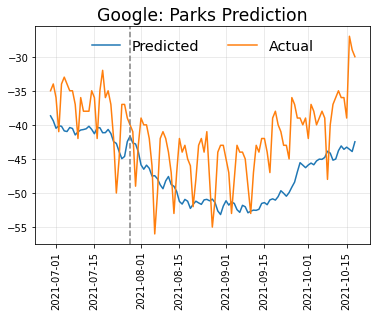

In [64]:

parks = pd.concat([y_mob_total_parks,
                data_mob0.parks.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

parks.columns = ['parks', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(parks['Date'],parks['parks'], label = "Predicted")
plt.plot(parks['Date'],parks['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Parks Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Transit

In [36]:
input_list = [np.expand_dims(data_mob.transit[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

# split into training and test sets
X_mob_tr_transit = X_mob[0:index+1, :]
X_mob_tr_transit = X_mob_tr_transit.reshape(X_mob_tr_transit.shape[0], X_mob_tr_transit.shape[1], 1)
X_mob_ts_transit = X_mob[index+1:data_mob.shape[0], :]
X_mob_ts_transit = X_mob_ts_transit.reshape(X_mob_ts_transit.shape[0], X_mob_ts_transit.shape[1], 1)

y_mob_tr_transit = y_mob[0:index+1, :, 3]
y_mob_ts_transit = y_mob[index+1:data_mob.shape[0], :, 3] # transit

## Tuning

In [37]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob_transit = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr_transit, y_mob_tr_transit)
    cnn_mob_transit.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr_transit, y_mob_tr_transit)
    cnn_mob_transit.append(score)

cnn_mob_transit = pd.DataFrame(cnn_mob_transit).T
cnn_mob_transit.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 3.406
filter = 4, kernel size = 3, pooling size = 2: 3.656
filter = 8, kernel size = 3, pooling size = 2: 3.856
filter = 16, kernel size = 3, pooling size = 2: 3.755
filter = 32, kernel size = 3, pooling size = 2: 4.380
filter = 64, kernel size = 3, pooling size = 2: 7.302
filter = 128, kernel size = 3, pooling size = 2: 8.669
filter = 256, kernel size = 3, pooling size = 2: 8.666
filter = 512, kernel size = 3, pooling size = 2: 9.240
filter = 1024, kernel size = 3, pooling size = 2: 9.900
filter = 2, kernel size = 5, pooling size = 2: 97.020
filter = 4, kernel size = 5, pooling size = 2: 97.023
filter = 8, kernel size = 5, pooling size = 2: 3.431
filter = 16, kernel size = 5, pooling size = 2: 4.020
filter = 32, kernel size = 5, pooling size = 2: 4.754
filter = 64, kernel size = 5, pooling size = 2: 8.305
filter = 128, kernel size = 5, pooling size = 2: 9.336
filter = 256, kernel size = 5, pooling size = 2: 9.278
filter = 512, kernel size

In [38]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob_transit = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr_transit, y_mob_tr_transit, i)
  lstm_mob_transit.append(score)

In [39]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob_transit = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr_transit, y_mob_tr_transit, i)
  gru_mob_transit.append(score)

In [40]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob_transit = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr_transit, y_mob_tr_transit, i)
  rnn_mob_transit.append(score)

### Table

In [65]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob_transit[0],3), 
                                     round(gru_mob_transit[0],3),
                                     round(rnn_mob_transit[0],3), 
                                     round(cnn_mob_transit.iloc[0,0],3),
                                     round(cnn_mob_transit.iloc[0,1],3),
                                     round(cnn_mob_transit.iloc[0,2],3),
                                     round(cnn_mob_transit.iloc[0,3],3),
                                     round(cnn_mob_transit.iloc[0,4],3),
                                     round(cnn_mob_transit.iloc[0,5],3)],
                                     [round(lstm_mob_transit[1],3), 
                                     round(gru_mob_transit[1],3),
                                     round(rnn_mob_transit[1],3), 
                                     round(cnn_mob_transit.iloc[1,0],3),
                                     round(cnn_mob_transit.iloc[1,1],3),
                                     round(cnn_mob_transit.iloc[1,2],3),
                                     round(cnn_mob_transit.iloc[1,3],3),
                                     round(cnn_mob_transit.iloc[1,4],3),
                                     round(cnn_mob_transit.iloc[1,5],3)],
                                     [round(lstm_mob_transit[2],3), 
                                     round(gru_mob_transit[2],3),
                                     round(rnn_mob_transit[2],3), 
                                     round(cnn_mob_transit.iloc[2,0],3),
                                     round(cnn_mob_transit.iloc[2,1],3),
                                     round(cnn_mob_transit.iloc[2,2],3),
                                     round(cnn_mob_transit.iloc[2,3],3),
                                     round(cnn_mob_transit.iloc[2,4],3),
                                     round(cnn_mob_transit.iloc[2,5],3)],
                                     [round(lstm_mob_transit[3],3), 
                                     round(gru_mob_transit[3],3),
                                     round(rnn_mob_transit[3],3), 
                                     round(cnn_mob_transit.iloc[3,0],3),
                                     round(cnn_mob_transit.iloc[3,1],3),
                                     round(cnn_mob_transit.iloc[3,2],3),
                                     round(cnn_mob_transit.iloc[3,3],3),
                                     round(cnn_mob_transit.iloc[3,4],3),
                                     round(cnn_mob_transit.iloc[3,5],3)],
                                     [round(lstm_mob_transit[4],3), 
                                     round(gru_mob_transit[4],3),
                                     round(rnn_mob_transit[4],3), 
                                     round(cnn_mob_transit.iloc[4,0],3),
                                     round(cnn_mob_transit.iloc[4,1],3),
                                     round(cnn_mob_transit.iloc[4,2],3),
                                     round(cnn_mob_transit.iloc[4,3],3),
                                     round(cnn_mob_transit.iloc[4,4],3),
                                     round(cnn_mob_transit.iloc[4,5],3)],
                                     [round(lstm_mob_transit[5],3), 
                                     round(gru_mob_transit[5],3),
                                     round(rnn_mob_transit[5],3), 
                                     round(cnn_mob_transit.iloc[5,0],3),
                                     round(cnn_mob_transit.iloc[5,1],3),
                                     round(cnn_mob_transit.iloc[5,2],3),
                                     round(cnn_mob_transit.iloc[5,3],3),
                                     round(cnn_mob_transit.iloc[5,4],3),
                                     round(cnn_mob_transit.iloc[5,5],3)],
                                     [round(lstm_mob_transit[6],3), 
                                     round(gru_mob_transit[6],3),
                                     round(rnn_mob_transit[6],3), 
                                     round(cnn_mob_transit.iloc[6,0],3),
                                     round(cnn_mob_transit.iloc[6,1],3),
                                     round(cnn_mob_transit.iloc[6,2],3),
                                     round(cnn_mob_transit.iloc[6,3],3),
                                     round(cnn_mob_transit.iloc[6,4],3),
                                     round(cnn_mob_transit.iloc[6,5],3)],
                                     [round(lstm_mob_transit[7],3), 
                                     round(gru_mob_transit[7],3),
                                     round(rnn_mob_transit[7],3), 
                                     round(cnn_mob_transit.iloc[7,0],3),
                                     round(cnn_mob_transit.iloc[7,1],3),
                                     round(cnn_mob_transit.iloc[7,2],3),
                                     round(cnn_mob_transit.iloc[7,3],3),
                                     round(cnn_mob_transit.iloc[7,4],3),
                                     round(cnn_mob_transit.iloc[7,5],3)],
                                     [round(lstm_mob_transit[8],3), 
                                     round(gru_mob_transit[8],3),
                                     round(rnn_mob_transit[8],3), 
                                     round(cnn_mob_transit.iloc[8,0],3),
                                     round(cnn_mob_transit.iloc[8,1],3),
                                     round(cnn_mob_transit.iloc[8,2],3),
                                     round(cnn_mob_transit.iloc[8,3],3),
                                     round(cnn_mob_transit.iloc[8,4],3),
                                     round(cnn_mob_transit.iloc[8,5],3)],
                                     [round(lstm_mob_transit[9],3), 
                                     round(gru_mob_transit[9],3),
                                     round(rnn_mob_transit[9],3), 
                                     round(cnn_mob_transit.iloc[9,0],3),
                                     round(cnn_mob_transit.iloc[9,1],3),
                                     round(cnn_mob_transit.iloc[9,2],3),
                                     round(cnn_mob_transit.iloc[9,3],3),
                                     round(cnn_mob_transit.iloc[9,4],3),
                                     round(cnn_mob_transit.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [66]:
seed(1)
tensorflow.random.set_seed(1)

model_mob_transit = Sequential()
model_mob_transit.add(SimpleRNN(8, activation='relu', input_shape=(X_mob_tr_transit.shape[1], X_mob_tr_transit.shape[2])))
# model_mob_transit.add(Dense(2, activation = "relu"))
model_mob_transit.add(Dense(1, activation = "linear"))
model_mob_transit.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_transit.fit(X_mob_tr_transit, y_mob_tr_transit, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob_transit.evaluate(X_mob_tr_transit, y_mob_tr_transit, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob_transit.evaluate(X_mob_ts_transit, y_mob_ts_transit, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr_transit = pd.DataFrame(model_mob_transit.predict(X_mob_tr_transit))

# test set
y_mob_ts_transit = pd.DataFrame(model_mob_transit.predict(X_mob_ts_transit))

# combine training and test predictions
y_mob_total_transit = pd.concat([y_mob_tr_transit, y_mob_ts_transit], ignore_index=True)



MAPE: training =  1.1588436365127563
MAPE: test =  1.660895824432373


## Plot

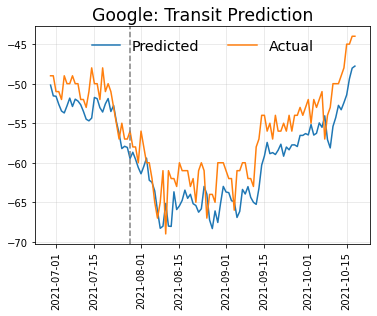

In [67]:

transit = pd.concat([y_mob_total_transit,
                data_mob0.transit.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

transit.columns = ['transit', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(transit['Date'],transit['transit'], label = "Predicted")
plt.plot(transit['Date'],transit['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Transit Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Workplace

In [44]:
input_list = [np.expand_dims(data_mob.workplace[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

# split into training and test sets
X_mob_tr_workplace = X_mob[0:index+1, :]
X_mob_tr_workplace = X_mob_tr_workplace.reshape(X_mob_tr_workplace.shape[0], X_mob_tr_workplace.shape[1], 1)
X_mob_ts_workplace = X_mob[index+1:data_mob.shape[0], :]
X_mob_ts_workplace = X_mob_ts_workplace.reshape(X_mob_ts_workplace.shape[0], X_mob_ts_workplace.shape[1], 1)

y_mob_tr_workplace = y_mob[0:index+1, :, 4]
y_mob_ts_workplace = y_mob[index+1:data_mob.shape[0], :, 4] # workplace

## Tuning

In [45]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob_workplace = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr_workplace, y_mob_tr_workplace)
    cnn_mob_workplace.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr_workplace, y_mob_tr_workplace)
    cnn_mob_workplace.append(score)

cnn_mob_workplace = pd.DataFrame(cnn_mob_workplace).T
cnn_mob_workplace.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 360412032.000
filter = 4, kernel size = 3, pooling size = 2: 115731024.000
filter = 8, kernel size = 3, pooling size = 2: 46022192.000
filter = 16, kernel size = 3, pooling size = 2: 25689594.000
filter = 32, kernel size = 3, pooling size = 2: 1613240.500
filter = 64, kernel size = 3, pooling size = 2: 10455196.000
filter = 128, kernel size = 3, pooling size = 2: 9942735.000
filter = 256, kernel size = 3, pooling size = 2: 6773973.000
filter = 512, kernel size = 3, pooling size = 2: 21882508.000
filter = 1024, kernel size = 3, pooling size = 2: 21350554.000
filter = 2, kernel size = 5, pooling size = 2: 173973776.000
filter = 4, kernel size = 5, pooling size = 2: 122417752.000
filter = 8, kernel size = 5, pooling size = 2: 89053920.000
filter = 16, kernel size = 5, pooling size = 2: 14464626.000
filter = 32, kernel size = 5, pooling size = 2: 19512654.000
filter = 64, kernel size = 5, pooling size = 2: 19017016.000
filter = 128, kernel siz

In [46]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob_workplace = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr_workplace, y_mob_tr_workplace, i)
  lstm_mob_workplace.append(score)

In [47]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob_workplace = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr_workplace, y_mob_tr_workplace, i)
  gru_mob_workplace.append(score)

In [48]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob_workplace = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr_workplace, y_mob_tr_workplace, i)
  rnn_mob_workplace.append(score)

### Table

In [49]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob_workplace[0],3), 
                                     round(gru_mob_workplace[0],3),
                                     round(rnn_mob_workplace[0],3), 
                                     round(cnn_mob_workplace.iloc[0,0],3),
                                     round(cnn_mob_workplace.iloc[0,1],3),
                                     round(cnn_mob_workplace.iloc[0,2],3),
                                     round(cnn_mob_workplace.iloc[0,3],3),
                                     round(cnn_mob_workplace.iloc[0,4],3),
                                     round(cnn_mob_workplace.iloc[0,5],3)],
                                     [round(lstm_mob_workplace[1],3), 
                                     round(gru_mob_workplace[1],3),
                                     round(rnn_mob_workplace[1],3), 
                                     round(cnn_mob_workplace.iloc[1,0],3),
                                     round(cnn_mob_workplace.iloc[1,1],3),
                                     round(cnn_mob_workplace.iloc[1,2],3),
                                     round(cnn_mob_workplace.iloc[1,3],3),
                                     round(cnn_mob_workplace.iloc[1,4],3),
                                     round(cnn_mob_workplace.iloc[1,5],3)],
                                     [round(lstm_mob_workplace[2],3), 
                                     round(gru_mob_workplace[2],3),
                                     round(rnn_mob_workplace[2],3), 
                                     round(cnn_mob_workplace.iloc[2,0],3),
                                     round(cnn_mob_workplace.iloc[2,1],3),
                                     round(cnn_mob_workplace.iloc[2,2],3),
                                     round(cnn_mob_workplace.iloc[2,3],3),
                                     round(cnn_mob_workplace.iloc[2,4],3),
                                     round(cnn_mob_workplace.iloc[2,5],3)],
                                     [round(lstm_mob_workplace[3],3), 
                                     round(gru_mob_workplace[3],3),
                                     round(rnn_mob_workplace[3],3), 
                                     round(cnn_mob_workplace.iloc[3,0],3),
                                     round(cnn_mob_workplace.iloc[3,1],3),
                                     round(cnn_mob_workplace.iloc[3,2],3),
                                     round(cnn_mob_workplace.iloc[3,3],3),
                                     round(cnn_mob_workplace.iloc[3,4],3),
                                     round(cnn_mob_workplace.iloc[3,5],3)],
                                     [round(lstm_mob_workplace[4],3), 
                                     round(gru_mob_workplace[4],3),
                                     round(rnn_mob_workplace[4],3), 
                                     round(cnn_mob_workplace.iloc[4,0],3),
                                     round(cnn_mob_workplace.iloc[4,1],3),
                                     round(cnn_mob_workplace.iloc[4,2],3),
                                     round(cnn_mob_workplace.iloc[4,3],3),
                                     round(cnn_mob_workplace.iloc[4,4],3),
                                     round(cnn_mob_workplace.iloc[4,5],3)],
                                     [round(lstm_mob_workplace[5],3), 
                                     round(gru_mob_workplace[5],3),
                                     round(rnn_mob_workplace[5],3), 
                                     round(cnn_mob_workplace.iloc[5,0],3),
                                     round(cnn_mob_workplace.iloc[5,1],3),
                                     round(cnn_mob_workplace.iloc[5,2],3),
                                     round(cnn_mob_workplace.iloc[5,3],3),
                                     round(cnn_mob_workplace.iloc[5,4],3),
                                     round(cnn_mob_workplace.iloc[5,5],3)],
                                     [round(lstm_mob_workplace[6],3), 
                                     round(gru_mob_workplace[6],3),
                                     round(rnn_mob_workplace[6],3), 
                                     round(cnn_mob_workplace.iloc[6,0],3),
                                     round(cnn_mob_workplace.iloc[6,1],3),
                                     round(cnn_mob_workplace.iloc[6,2],3),
                                     round(cnn_mob_workplace.iloc[6,3],3),
                                     round(cnn_mob_workplace.iloc[6,4],3),
                                     round(cnn_mob_workplace.iloc[6,5],3)],
                                     [round(lstm_mob_workplace[7],3), 
                                     round(gru_mob_workplace[7],3),
                                     round(rnn_mob_workplace[7],3), 
                                     round(cnn_mob_workplace.iloc[7,0],3),
                                     round(cnn_mob_workplace.iloc[7,1],3),
                                     round(cnn_mob_workplace.iloc[7,2],3),
                                     round(cnn_mob_workplace.iloc[7,3],3),
                                     round(cnn_mob_workplace.iloc[7,4],3),
                                     round(cnn_mob_workplace.iloc[7,5],3)],
                                     [round(lstm_mob_workplace[8],3), 
                                     round(gru_mob_workplace[8],3),
                                     round(rnn_mob_workplace[8],3), 
                                     round(cnn_mob_workplace.iloc[8,0],3),
                                     round(cnn_mob_workplace.iloc[8,1],3),
                                     round(cnn_mob_workplace.iloc[8,2],3),
                                     round(cnn_mob_workplace.iloc[8,3],3),
                                     round(cnn_mob_workplace.iloc[8,4],3),
                                     round(cnn_mob_workplace.iloc[8,5],3)],
                                     [round(lstm_mob_workplace[9],3), 
                                     round(gru_mob_workplace[9],3),
                                     round(rnn_mob_workplace[9],3), 
                                     round(cnn_mob_workplace.iloc[9,0],3),
                                     round(cnn_mob_workplace.iloc[9,1],3),
                                     round(cnn_mob_workplace.iloc[9,2],3),
                                     round(cnn_mob_workplace.iloc[9,3],3),
                                     round(cnn_mob_workplace.iloc[9,4],3),
                                     round(cnn_mob_workplace.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [68]:
seed(1)
tensorflow.random.set_seed(1)

# model_mob_workplace = Sequential()
# model_mob_workplace.add(Conv1D(256, kernel_size = 5, activation='relu', input_shape=(X_mob_tr_workplace.shape[1], X_mob_tr_workplace.shape[2])))
# model_mob_workplace.add(MaxPooling1D(2))
# model_mob_workplace.add(Flatten())
# model_mob_workplace.add(Dense(32, activation = "relu"))
# model_mob_workplace.add(Dense(1, activation = "linear"))
# model_mob_workplace.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_mob_workplace = Sequential()
model_mob_workplace.add(LSTM(1024, activation='relu', input_shape=(X_mob_tr_workplace.shape[1], X_mob_tr_workplace.shape[2])))
# model_mob_workplace.add(Dense(2, activation = "relu"))
model_mob_workplace.add(Dense(1, activation = "linear"))
model_mob_workplace.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_workplace.fit(X_mob_tr_workplace, y_mob_tr_workplace, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob_workplace.evaluate(X_mob_tr_workplace, y_mob_tr_workplace, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob_workplace.evaluate(X_mob_ts_workplace, y_mob_ts_workplace, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr_workplace = pd.DataFrame(model_mob_workplace.predict(X_mob_tr_workplace))

# test set
y_mob_ts_workplace = pd.DataFrame(model_mob_workplace.predict(X_mob_ts_workplace))

# combine training and test predictions
y_mob_total_workplace = pd.concat([y_mob_tr_workplace, y_mob_ts_workplace], ignore_index=True)



MAPE: training =  7.181046962738037
MAPE: test =  37.73136520385742


## Plot

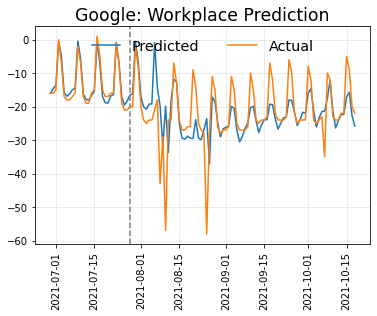

In [69]:

workplace = pd.concat([y_mob_total_workplace,
                data_mob0.workplace.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

workplace.columns = ['workplace', "Actual", 'Date']

tick_spacing = 5
date_test = data_mob0['Date'][0+index+lag-1]

plt.plot(workplace['Date'],workplace['workplace'], label = "Predicted")
plt.plot(workplace['Date'],workplace['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Workplace Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)


# Resident

In [52]:
input_list = [np.expand_dims(data_mob.resident[i:lag+i], axis=0) for i in range(nrow_total)] 
X_mob = np.concatenate(input_list, axis=0)

# split into training and test sets
X_mob_tr_resident = X_mob[0:index+1, :]
X_mob_tr_resident = X_mob_tr_resident.reshape(X_mob_tr_resident.shape[0], X_mob_tr_resident.shape[1], 1)
X_mob_ts_resident = X_mob[index+1:data_mob.shape[0], :]
X_mob_ts_resident = X_mob_ts_resident.reshape(X_mob_ts_resident.shape[0], X_mob_ts_resident.shape[1], 1)

y_mob_tr_resident = y_mob[0:index+1, :, 5]
y_mob_ts_resident = y_mob[index+1:data_mob.shape[0], :, 5] # resident

## Tuning

In [53]:
# CNN Tuning

def evaluate_cnn(trainX, trainy, filter, kernel_size, pool):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(Conv1D(filters = filter, kernel_size=kernel_size, activation='relu',input_shape=(n_timesteps,n_features)))
    model.add(MaxPooling1D(pool_size= pool))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

# run an experiment
def run_experiment(filters, kernel_size, pool, trainX, trainy):
    # test each parameter
    all_scores = list()
    for filter in filters:
      for kernel in kernel_size:
        for pooling in pool:
          score = evaluate_cnn(trainX, trainy, filter, kernel_size, pool)
          print('filter = %d, kernel size = %d, pooling size = %d: %.3f' % (filter, kernel, pooling, score))
          all_scores.append(score)
    return all_scores
    


filter = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] 

kernel = [3, 5, 7]
pool = [2]
cnn_mob_resident = list()

for i in kernel:
  for j in pool: 
    score = list()
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool,X_mob_tr_resident, y_mob_tr_resident)
    cnn_mob_resident.append(score)

pool = [3]

for i in kernel:
  for j in pool: 
    kernel_size, pool = [i],[j]
    score = run_experiment(filter, kernel_size, pool, X_mob_tr_resident, y_mob_tr_resident)
    cnn_mob_resident.append(score)

cnn_mob_resident = pd.DataFrame(cnn_mob_resident).T
cnn_mob_resident.columns = ['k3p2', 'k5p2','k7p2', 'k3p3', 'k5p3', 'k7p3']

filter = 2, kernel size = 3, pooling size = 2: 29.615
filter = 4, kernel size = 3, pooling size = 2: 22.402
filter = 8, kernel size = 3, pooling size = 2: 19.052
filter = 16, kernel size = 3, pooling size = 2: 19.224
filter = 32, kernel size = 3, pooling size = 2: 15.330
filter = 64, kernel size = 3, pooling size = 2: 15.311
filter = 128, kernel size = 3, pooling size = 2: 12.794
filter = 256, kernel size = 3, pooling size = 2: 10.225
filter = 512, kernel size = 3, pooling size = 2: 9.426
filter = 1024, kernel size = 3, pooling size = 2: 8.954
filter = 2, kernel size = 5, pooling size = 2: 24.009
filter = 4, kernel size = 5, pooling size = 2: 23.234
filter = 8, kernel size = 5, pooling size = 2: 22.094
filter = 16, kernel size = 5, pooling size = 2: 20.134
filter = 32, kernel size = 5, pooling size = 2: 18.159
filter = 64, kernel size = 5, pooling size = 2: 17.986
filter = 128, kernel size = 5, pooling size = 2: 11.924
filter = 256, kernel size = 5, pooling size = 2: 8.261
filter = 512

In [54]:
# LSTM
def evaluate_lstm(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(LSTM(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy


units = [2, 4,8,16,32,64,128,256,512, 1024]

lstm_mob_resident = list()

for i in units:
  score = list()
  score = evaluate_lstm(X_mob_tr_resident, y_mob_tr_resident, i)
  lstm_mob_resident.append(score)

In [55]:
# GRU
def evaluate_gru(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(GRU(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

gru_mob_resident = list()

for i in units:
  score = list()
  score = evaluate_gru(X_mob_tr_resident, y_mob_tr_resident, i)
  gru_mob_resident.append(score)

In [56]:
# RNN
def evaluate_rnn(trainX, trainy, units):
    seed(1)
    tensorflow.random.set_seed(1)

    verbose, epochs, batch_size = 0, 50, 1
    n_timesteps, n_features = trainX.shape[1], trainX.shape[2]

    model = Sequential()
    model.add(SimpleRNN(units = units, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['MAPE'])
  
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = False)
    # evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=0)
    return accuracy

rnn_mob_resident = list()

for i in units:
  score = list()
  score = evaluate_rnn(X_mob_tr_resident, y_mob_tr_resident, i)
  rnn_mob_resident.append(score)

### Table

In [70]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Kernel size', 'Pool', '2 Nodes', '4 Nodes', '8 Nodes', '16 Nodes', '32 Nodes',
                                                   "64 Nodes", '128 Nodes', '256 Nodes', '512 Nodes', '1024 Nodes'],
                                           line_color = 'gray'),
                               cells=dict(values=[['LSTM', 'GRU', 'RNNs', 'CNN',
                                                   'CNN', 'CNN', 'CNN', 'CNN', 'CNN'],
                                                  ['-', '-', '-', '3', '5', '7', '3', '5', '7'],
                                                  ['-', '-', '-', '2', '2', '2', '3', '3', '3'],
                                    [round(lstm_mob_resident[0],3), 
                                     round(gru_mob_resident[0],3),
                                     round(rnn_mob_resident[0],3), 
                                     round(cnn_mob_resident.iloc[0,0],3),
                                     round(cnn_mob_resident.iloc[0,1],3),
                                     round(cnn_mob_resident.iloc[0,2],3),
                                     round(cnn_mob_resident.iloc[0,3],3),
                                     round(cnn_mob_resident.iloc[0,4],3),
                                     round(cnn_mob_resident.iloc[0,5],3)],
                                     [round(lstm_mob_resident[1],3), 
                                     round(gru_mob_resident[1],3),
                                     round(rnn_mob_resident[1],3), 
                                     round(cnn_mob_resident.iloc[1,0],3),
                                     round(cnn_mob_resident.iloc[1,1],3),
                                     round(cnn_mob_resident.iloc[1,2],3),
                                     round(cnn_mob_resident.iloc[1,3],3),
                                     round(cnn_mob_resident.iloc[1,4],3),
                                     round(cnn_mob_resident.iloc[1,5],3)],
                                     [round(lstm_mob_resident[2],3), 
                                     round(gru_mob_resident[2],3),
                                     round(rnn_mob_resident[2],3), 
                                     round(cnn_mob_resident.iloc[2,0],3),
                                     round(cnn_mob_resident.iloc[2,1],3),
                                     round(cnn_mob_resident.iloc[2,2],3),
                                     round(cnn_mob_resident.iloc[2,3],3),
                                     round(cnn_mob_resident.iloc[2,4],3),
                                     round(cnn_mob_resident.iloc[2,5],3)],
                                     [round(lstm_mob_resident[3],3), 
                                     round(gru_mob_resident[3],3),
                                     round(rnn_mob_resident[3],3), 
                                     round(cnn_mob_resident.iloc[3,0],3),
                                     round(cnn_mob_resident.iloc[3,1],3),
                                     round(cnn_mob_resident.iloc[3,2],3),
                                     round(cnn_mob_resident.iloc[3,3],3),
                                     round(cnn_mob_resident.iloc[3,4],3),
                                     round(cnn_mob_resident.iloc[3,5],3)],
                                     [round(lstm_mob_resident[4],3), 
                                     round(gru_mob_resident[4],3),
                                     round(rnn_mob_resident[4],3), 
                                     round(cnn_mob_resident.iloc[4,0],3),
                                     round(cnn_mob_resident.iloc[4,1],3),
                                     round(cnn_mob_resident.iloc[4,2],3),
                                     round(cnn_mob_resident.iloc[4,3],3),
                                     round(cnn_mob_resident.iloc[4,4],3),
                                     round(cnn_mob_resident.iloc[4,5],3)],
                                     [round(lstm_mob_resident[5],3), 
                                     round(gru_mob_resident[5],3),
                                     round(rnn_mob_resident[5],3), 
                                     round(cnn_mob_resident.iloc[5,0],3),
                                     round(cnn_mob_resident.iloc[5,1],3),
                                     round(cnn_mob_resident.iloc[5,2],3),
                                     round(cnn_mob_resident.iloc[5,3],3),
                                     round(cnn_mob_resident.iloc[5,4],3),
                                     round(cnn_mob_resident.iloc[5,5],3)],
                                     [round(lstm_mob_resident[6],3), 
                                     round(gru_mob_resident[6],3),
                                     round(rnn_mob_resident[6],3), 
                                     round(cnn_mob_resident.iloc[6,0],3),
                                     round(cnn_mob_resident.iloc[6,1],3),
                                     round(cnn_mob_resident.iloc[6,2],3),
                                     round(cnn_mob_resident.iloc[6,3],3),
                                     round(cnn_mob_resident.iloc[6,4],3),
                                     round(cnn_mob_resident.iloc[6,5],3)],
                                     [round(lstm_mob_resident[7],3), 
                                     round(gru_mob_resident[7],3),
                                     round(rnn_mob_resident[7],3), 
                                     round(cnn_mob_resident.iloc[7,0],3),
                                     round(cnn_mob_resident.iloc[7,1],3),
                                     round(cnn_mob_resident.iloc[7,2],3),
                                     round(cnn_mob_resident.iloc[7,3],3),
                                     round(cnn_mob_resident.iloc[7,4],3),
                                     round(cnn_mob_resident.iloc[7,5],3)],
                                     [round(lstm_mob_resident[8],3), 
                                     round(gru_mob_resident[8],3),
                                     round(rnn_mob_resident[8],3), 
                                     round(cnn_mob_resident.iloc[8,0],3),
                                     round(cnn_mob_resident.iloc[8,1],3),
                                     round(cnn_mob_resident.iloc[8,2],3),
                                     round(cnn_mob_resident.iloc[8,3],3),
                                     round(cnn_mob_resident.iloc[8,4],3),
                                     round(cnn_mob_resident.iloc[8,5],3)],
                                     [round(lstm_mob_resident[9],3), 
                                     round(gru_mob_resident[9],3),
                                     round(rnn_mob_resident[9],3), 
                                     round(cnn_mob_resident.iloc[9,0],3),
                                     round(cnn_mob_resident.iloc[9,1],3),
                                     round(cnn_mob_resident.iloc[9,2],3),
                                     round(cnn_mob_resident.iloc[9,3],3),
                                     round(cnn_mob_resident.iloc[9,4],3),
                                     round(cnn_mob_resident.iloc[9,5],3)]],
                            align=['left','center', 'center', 
                                   'right','right','right',
                                   'right','right','right',
                                   'right','right', 'right', 'right'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Parameter Tunings Mean Absolute Percentage Error: Google Mobility",
                  title_x=0.5, height = 700, width = 1200)
fig.show()

## Prediction

In [71]:
seed(1)
tensorflow.random.set_seed(1)

# model_mob_resident = Sequential()
# model_mob_resident.add(Conv1D(128, kernel_size = 5, activation='relu', input_shape=(X_mob_tr_resident.shape[1], X_mob_tr_resident.shape[2])))
# model_mob_resident.add(MaxPooling1D(3))
# model_mob_resident.add(Flatten())
# # model_mob_resident.add(Dense(2, activation = "relu"))
# model_mob_resident.add(Dense(1, activation = "linear"))
# model_mob_resident.compile(loss='mse', optimizer='adam', metrics = "MAPE")

model_mob_resident = Sequential()
model_mob_resident.add(SimpleRNN(32, activation='relu', input_shape=(X_mob_tr_resident.shape[1], X_mob_tr_resident.shape[2])))
# model_mob_resident.add(Dense(2, activation = "relu"))
model_mob_resident.add(Dense(1, activation = "linear"))
model_mob_resident.compile(loss='mse', optimizer='adam', metrics = "MAPE")

# fit network
model_mob_resident.fit(X_mob_tr_resident, y_mob_tr_resident, 
                           epochs=50, 
                           batch_size=1, 
                           verbose=0, 
                           shuffle=False)

scores_mob1 = model_mob_resident.evaluate(X_mob_tr_resident, y_mob_tr_resident, verbose=0)

# MAPE
print("MAPE: training = ",scores_mob1[1])

scores_mob = model_mob_resident.evaluate(X_mob_ts_resident, y_mob_ts_resident, verbose=0)

# MAPE
print("MAPE: test = ",scores_mob[1])


# make a prediction
# training set
y_mob_tr_resident = pd.DataFrame(model_mob_resident.predict(X_mob_tr_resident))

# test set
y_mob_ts_resident = pd.DataFrame(model_mob_resident.predict(X_mob_ts_resident))

# combine training and test predictions
y_mob_total_resident = pd.concat([y_mob_tr_resident, y_mob_ts_resident], ignore_index=True)



MAPE: training =  7.165075778961182
MAPE: test =  10.847747802734375


## Plot

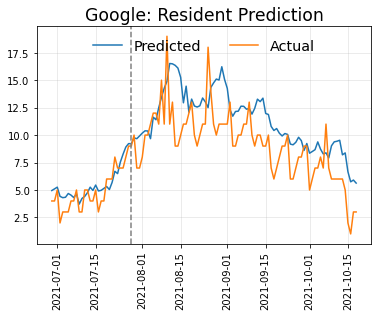

In [72]:

resident = pd.concat([y_mob_total_resident,
                data_mob0.resident.iloc[lag:].reset_index(drop = True),
                data_mob0.Date.iloc[lag:].reset_index(drop = True)], axis=1)

resident.columns = ['resident', "Actual", 'Date']


plt.plot(resident['Date'],resident['resident'], label = "Predicted")
plt.plot(resident['Date'],resident['Actual'], label = "Actual")
plt.legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
plt.title("Google: Resident Prediction", fontsize = 'xx-large')
plt.tick_params('x',labelrotation=90)
plt.axvline(date_test, color="gray", linestyle="--")
plt.grid(True, which='both', alpha=0.3)
